## Load Libraries and Data

In [25]:
# note: this notebook requires pandas 0.21.0 or newer
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf
import math
from datetime import datetime as dt
import re as re
from sklearn.datasets import load_boston
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.impute import SimpleImputer

In [26]:
# Basic EDA
# The training data needs to be saved in the same location.
original_data = pd.read_csv('train.csv')
data = original_data.copy()

# Background to the problem (Hilary)

## Feature Engineering (YW)

### Overview

We have two broad approaches to feature engineering - 'top down' and 'bottom up'. In the 'top down' case, we start with all the variables and work to eliminate / simplify variables as much as possible. We remove features with little useful variation (mostly missing, or heavily imbalanced) and features that are highly correlated for obvious reasons (e.g. total square feet and other component square feet). These should help to reduce the likelihood of overfitting and help improve interpretability. 

In the 'bottom up' case, we use various algorithmic feature selection techniques (e.g. random forest feature importance) and choose the top 10. This helps us construct the most parsimonious feature set to compare our more complete feature set against. 

In both cases, we also make several variable transformations - imputing missing features, or one-hot-encoding categorical features, for instance. They are listed below. 

### Remove features with very little variation and those that are missing for most observations

Based on this heatmap of missing variables we see that Alley, PoolQC, Fence and MiscFeature are missing for most values in the dataset. This makes sense, as these are more esoteric feature sof the house. In the same vein, there is also very little variation in Street, Utilities, LowQualFinSF and MiscVal. For example, most of these houses have all the utilities except for one. While this may ultimately be an important predictor, we believe that this is more likely to overfit and not generalize (after all this observation can only be in validation or train) for any given fold.

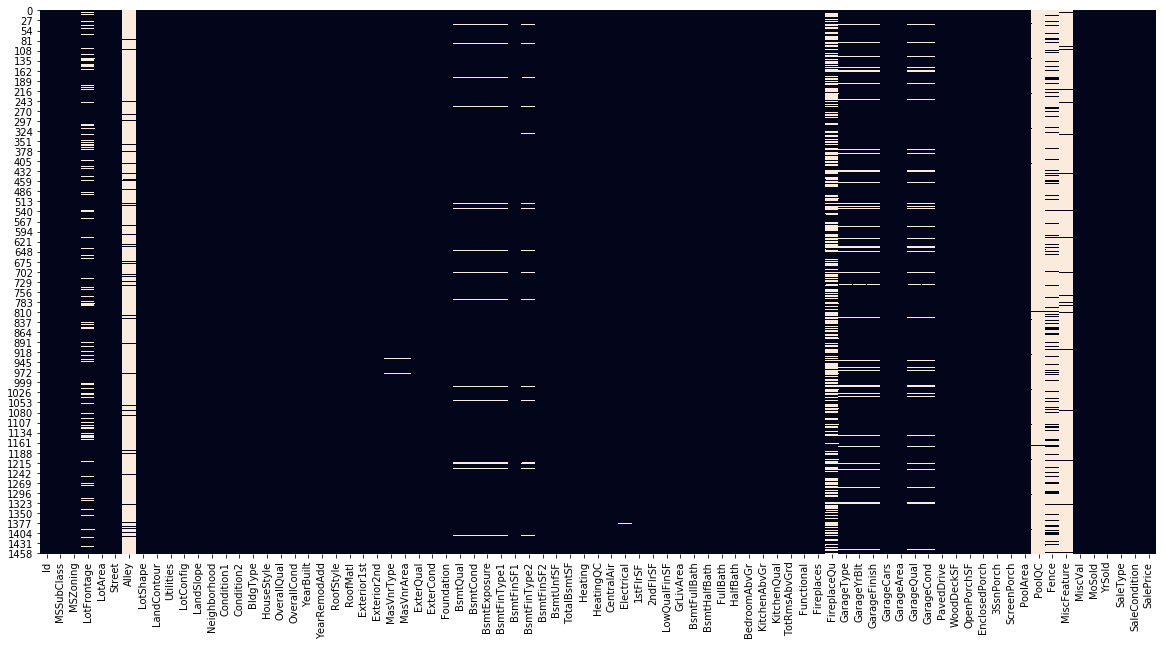

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(original_data.isnull(), cbar=False)
data = data.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Drop variables with very imblanced categories or mostly missing
data = data.drop(columns = ['Street', 'Utilities', 'LowQualFinSF', 'MiscVal'])

### Remove features that are redundant given other variables

We then remove aggregated variables that are very close to the sum of its component parts. For instance, TotalBsmtSF is the approximately sum of the BsmtFinSF1, BSmtUnfSF and BsmtFinSF2. Likewise with GrLivArea. There are some minor discrepancies, but I assume that those are immaterial for our analysis and not large/frequent enough to matter. 

GarageArea / GarageCars is an interesting case, as these two variables capture a similar concept. Indeed, the two variables are highly correlated (see chart below). We keep both in for now, but may decide to remove the 'less informative' one later (e.g. GarageCars). 

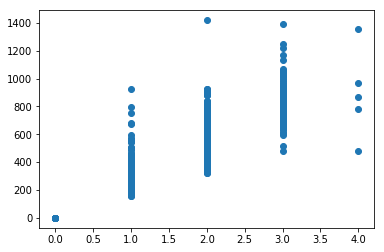

In [28]:
##################
### BASEMENTSF ###
# Drop the aggregate BsmtSF variable
test = pd.DataFrame()
test['DiffBsmtSF'] = original_data["TotalBsmtSF"] - original_data['BsmtFinSF1'] - original_data['BsmtUnfSF'] - original_data['BsmtFinSF2']
test['DiffBsmtSF'].value_counts()

# Remove variable
data = data.drop(columns=['TotalBsmtSF'])

##################
### GRLIVAREA ###
# Is GrLivArea simply the sum of 1st and 2nd?
# Most of hte time it is - there are 5 observations that are not, but doesn't seem like a goood reason to keep
test = pd.DataFrame()
test['GrLivArea'] = original_data["GrLivArea"]
test['1stAnd2nd'] = original_data["1stFlrSF"] + original_data["2ndFlrSF"]
test['Diff'] = test['GrLivArea'] - test['1stAnd2nd']
test['Diff'].value_counts()

###################
### GARAGECARS ###
data = data.drop(columns = ['GrLivArea'])
original_data['GarageCars'].value_counts()
plt.scatter(original_data['GarageCars'],original_data['GarageArea'])
#data = data.drop(columns=['GarageCars']) # KEEP FOR NOW, but garage area may be better than garage cars

###################
### DATETIME    ###
# Change date to ordinal representation:
data['YrMoSold'] = data['YrSold'].astype(int).astype(str) + "/" + data['MoSold'].astype(int).astype(str) + "/1"
data['YrMoSold'] = data['YrMoSold'].apply(lambda x: dt.strptime(x, "%Y/%m/%d").date().toordinal())

### Impute features

We use the median values to impute missing values to control for possible outliers. We also do not impute any missing categories for now (they will receive 0 across all one-hot encoded dummy variables). In a later analysis, we might do more complex imputation of these missing values. 

In [29]:
#############################
# Impute all numeric missings (all dummy missings are coded 0)
imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
data_numeric = imp.fit_transform(data.select_dtypes(exclude='object'))
data_numeric = pd.DataFrame(data_numeric, columns = data.select_dtypes(exclude='object').columns)
data = pd.concat([data.select_dtypes(include='object'), data_numeric], axis = 1)

### Combine sparse categories in some features

Condition and Exterior features have many sparse levels - we group levels that have very few observations to obtain a bigger category. 

In [30]:
# Combine categories - very thin categories
# Condition1
data['Condition1'] = np.where(data['Condition1']=='Norm', 'Norm', 'Not_Norm')
data['Condition2'] = np.where(data['Condition2']=='Norm', 'Norm', 'Not_Norm')

# Exterior1st
data['Exterior1st'] = np.where(data['Exterior1st'].isin(['BrkComm', 'Stone', 'AsphShn', 'ImStucc', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])
data['Exterior2nd'] = np.where(data['Exterior2nd'].isin(['Brk Cmn', 'Stone', 'AsphShn', 'Other', "CBlock", "WdShing", "Stucco", "AsbShng"]), 'Other', data['Exterior1st'])


### One-Hot-Encoding for Categoricals

We use one-hot encoding to encode categorical features and combine the condition and exterior variables into one variable each. 

In [31]:
##########################
# Binarize all categorical (one-hot)
data = pd.get_dummies(data)

In [32]:
# Simplify the Condition Feature
data['Condition_Norm'] = data['Condition1_Norm'] + data['Condition2_Norm']
data['Condition_Not_Norm'] = data['Condition1_Not_Norm'] + data['Condition2_Not_Norm']
data['Condition_Norm'] = np.where(data['Condition_Norm']==2, 1, data['Condition_Norm'])
data['Condition_Not_Norm'] = np.where(data['Condition_Not_Norm']==2, 1, data['Condition_Not_Norm'])

# Simplify the Exterior Feature
data['Exterior_VinylSd'] = data['Exterior1st_VinylSd'] + data['Exterior2nd_VinylSd']
data['Exterior_HdBoard'] = data['Exterior1st_HdBoard'] + data['Exterior2nd_HdBoard']
data['Exterior_MetalSd'] = data['Exterior1st_MetalSd'] + data['Exterior2nd_MetalSd']
data['Exterior_Wd Sdng'] = data['Exterior1st_Wd Sdng'] + data['Exterior2nd_Wd Sdng']
data['Exterior_Plywood'] = data['Exterior1st_Plywood'] + data['Exterior2nd_Plywood']
data['Exterior_Other']   = data['Exterior1st_Other']   + data['Exterior2nd_Other']
data['Exterior_CemntBd'] = data['Exterior1st_CemntBd'] + data['Exterior2nd_CemntBd']
data['Exterior_BrkFace'] = data['Exterior1st_BrkFace'] + data['Exterior2nd_BrkFace']

data['Exterior_VinylSd'] = np.where(data['Exterior_VinylSd'] == 2, 1, data['Exterior_VinylSd'])
data['Exterior_HdBoard'] = np.where(data['Exterior_HdBoard'] == 2, 1, data['Exterior_HdBoard'])
data['Exterior_MetalSd'] = np.where(data['Exterior_MetalSd'] == 2, 1, data['Exterior_MetalSd'])
data['Exterior_Wd Sdng'] = np.where(data['Exterior_Wd Sdng'] == 2, 1, data['Exterior_Wd Sdng'])
data['Exterior_Plywood'] = np.where(data['Exterior_Plywood'] == 2, 1, data['Exterior_Plywood'])
data['Exterior_Other'] = np.where(data['Exterior_Other'] == 2, 1, data['Exterior_Other'])
data['Exterior_CemntBd'] = np.where(data['Exterior_CemntBd'] == 2, 1, data['Exterior_CemntBd'])
data['Exterior_BrkFace'] = np.where(data['Exterior_BrkFace'] == 2, 1, data['Exterior_BrkFace'])

cols_to_drop = list(filter(lambda x: re.search(r'Condition1|Condition2|Exterior1|Exterior2', x), data.columns))
data = data.drop(columns=cols_to_drop)

### Convert features to the right type

In [33]:
data['OverallQual'] = original_data['OverallQual'].astype('category')
data['OverallCond'] = original_data['OverallCond'].astype('category', ordered=True)
data['MSSubClass'] = original_data['MSSubClass'].astype('category')

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


### Add new features

In [34]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Condition_Norm,Condition_Not_Norm,Exterior_VinylSd,Exterior_HdBoard,Exterior_MetalSd,Exterior_Wd Sdng,Exterior_Plywood,Exterior_Other,Exterior_CemntBd,Exterior_BrkFace
0,1.0,60,65.0,8450.0,7,5,2003.0,2003.0,196.0,706.0,...,1,0,1,0,0,0,0,0,0,0
1,2.0,20,80.0,9600.0,6,8,1976.0,1976.0,0.0,978.0,...,1,1,0,0,1,0,0,0,0,0
2,3.0,60,68.0,11250.0,7,5,2001.0,2002.0,162.0,486.0,...,1,0,1,0,0,0,0,0,0,0
3,4.0,70,60.0,9550.0,7,5,1915.0,1970.0,0.0,216.0,...,1,0,0,0,0,1,0,0,0,0
4,5.0,60,84.0,14260.0,8,5,2000.0,2000.0,350.0,655.0,...,1,0,1,0,0,0,0,0,0,0


### Some basic feature importance to sense check

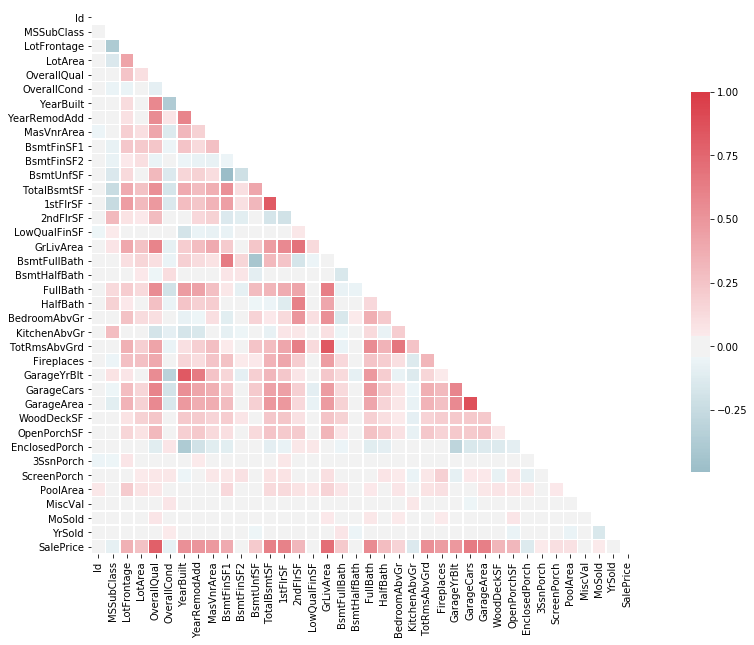

In [35]:
# Correlation matrix
plt.figure(figsize=(20,10))
corr = original_data.select_dtypes(exclude='object').corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Use an algorithmic Feature Selection method

In [36]:
remove_variables = ['SalePrice']

rf = RandomForestRegressor()
rf.fit(data.drop(columns=['SalePrice']), data['SalePrice'])
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_.round(4),
                                   index = data.drop(columns=['SalePrice']).columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances[1:10]

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
2ndFlrSF,0.0453
1stFlrSF,0.0453
GarageArea,0.0296
BsmtFinSF1,0.0268
GarageCars,0.0239
LotArea,0.0194
TotRmsAbvGrd,0.0172
FullBath,0.0141
LotFrontage,0.0123


### Create a Simple Version with fewer variables

In [37]:
### Create a really simple version with 10 variables
most_impt_cols = list(feature_importances[:10].index)
most_impt_cols.append('SalePrice')

def get_simple_data(input_data, colnames):
    output_data = input_data[colnames]
    return(output_data)
    
data = get_simple_data(data, most_impt_cols)

In [38]:
data.head()

,OverallQual,2ndFlrSF,1stFlrSF,GarageArea,BsmtFinSF1,GarageCars,LotArea,TotRmsAbvGrd,FullBath,LotFrontage,SalePrice
0,7,854.0,856.0,548.0,706.0,2.0,8450.0,8.0,2.0,65.0,208500.0
1,6,0.0,1262.0,460.0,978.0,2.0,9600.0,6.0,2.0,80.0,181500.0
2,7,866.0,920.0,608.0,486.0,2.0,11250.0,6.0,2.0,68.0,223500.0
3,7,756.0,961.0,642.0,216.0,3.0,9550.0,7.0,1.0,60.0,140000.0
4,8,1053.0,1145.0,836.0,655.0,3.0,14260.0,9.0,2.0,84.0,250000.0


### Test and Dev Data

In [39]:
# Labels
train_labels = data['SalePrice']

# Data
split = 500
train_data = data.drop(columns=['SalePrice']).copy()

# Split train data and dev Data
dev_data = train_data[:split]
train_data = train_data[split:]
dev_labels = train_labels[:split]
train_labels = train_labels[split:]

train_data.describe()

,2ndFlrSF,1stFlrSF,GarageArea,BsmtFinSF1,GarageCars,LotArea,TotRmsAbvGrd,FullBath,LotFrontage
count,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000
mean,348.284375,1162.717708,478.302083,443.412500,1.780208,10190.564583,6.534375,1.569792,69.469792
std,436.624200,391.669804,216.802867,464.655041,0.742445,6436.340166,1.670721,0.551161,22.520414
min,0.000000,334.000000,0.000000,0.000000,0.000000,1300.000000,2.000000,0.000000,21.000000
25%,0.000000,880.000000,336.000000,0.000000,1.000000,7500.000000,5.000000,1.000000,60.000000
50%,0.000000,1080.000000,480.000000,383.500000,2.000000,9528.000000,6.000000,2.000000,69.000000
75%,729.750000,1391.000000,577.000000,713.750000,2.000000,11601.500000,7.000000,2.000000,78.000000
max,2065.000000,4692.000000,1418.000000,5644.000000,4.000000,115149.000000,14.000000,3.000000,313.000000


## Run Baseline & Early Models

We started with a simple 15% dev set, but we have found that for this amount of data, the differences in the models and their scores on the dev sets can vary significantly based on which rows end up in the train and dev sets. Repeated random sub-sampling cross validation helps us get more consistent results.

In [42]:
# still to do : choose one version of pandas to use so that our code all agrees
# and I don't have to read in a new dataset here 
data_df = pd.read_csv('clean_data.csv')
data_df['LogSalePrice'] = np.log(data_df['SalePrice'])
NUM_CROSS_VALS = 20

In [43]:
# get the list of different cross val splits
cross_val_list = []
for i in range(NUM_CROSS_VALS):
    split_idx = int(data_df.shape[0] * .85)
    # line below is what shuffles
    data_df = data_df.sample(frac=1)
    train_df = data_df[:split_idx]
    dev_df = data_df[split_idx:]
    split_dict = {'train_df': train_df,
                  'dev_df': dev_df}
    cross_val_list.append(split_dict)

As our primary error metric, we focus on the root mean squared error of the logarithm of the prices, which is the error metric being used to create the leaderboard for this kaggle competition. See rmsle() in shared_functions.py for our implementation of the root mean squared error, an implementation we found from Mark Nagelberg on Kaggle: https://www.kaggle.com/marknagelberg/rmsle-function.

When we consulted our resident real estate expert, Hilary's dad, about this problem, he told us that only one of these factors matters - "location, location, location." In the spirit of that insight, we created a baseline "model" which looks at what neighborhood the house is in and takes the mean price of houses from that neighborhood in the training set. 

In [44]:
# todo: figure out why i'm getting nans now
# when i wasn't in original notebook
def baseline_pred(row,
                  train_df):
    for col in train_df:
        if 'Neighborhood' in col:
            if row[col] == 1:
                neighborhood_var = col
                break
    return np.nanmean(train_df[train_df[neighborhood_var]==1]['LogSalePrice'])

def get_baseline_cross_val(cross_val_list):
    all_rmses = []
    for di in cross_val_list:
        dev_df = di['dev_df']
        dev_df['baseline_pred'] = dev_df.apply(lambda row: baseline_pred(row,
                                                                         di['train_df']), axis=1)
        rmse = sf.rmsle(list(np.exp(dev_df['LogSalePrice'])), list(np.exp(dev_df['baseline_pred'])))
        all_rmses.append(rmse)
    return np.nanmean(all_rmses) 

# baseline RMSLE
print("Baseline RMSLE: {:.3f}".format(get_baseline_cross_val(cross_val_list)))

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Baseline RMSLE: 0.268


/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With this as a baseline, we began exploring how different types of models perform on the problem.

#### Linear Regression

We begin with linear regression as the standard choice for a regression problem. In ordinary least squares regression, the regression line is fit by minimizing the sum of squared residuals between the predicted line and the true data points. We can interpret the resulting coefficients on each feature as representing the additional impact of a one-unit change in that feature on the final price.

In [45]:
models = [LinearRegression()]
outcome_vars = ['LogSalePrice']
feature_sets = [[col for col in data_df.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice']]]
lrdf = sf.try_different_models(cross_val_list, models, outcome_vars, feature_sets)
lrdf.sort_values('Root MSE', ascending=True)

,Features,Model,Num Features,Outcome Var,Root MSE
0,"[Unnamed: 0, Id, LotFrontage, LotArea, YearBui...","LinearRegression(copy_X=True, fit_intercept=Tr...",300,LogSalePrice,0.145724


#### Tree-based regressors

The family of tree-based regressors learns a series of simple decision rules to predict the final sale price. The decision tree regressor makes one single Decision Tree, whereas the Random Forest regressor trains an ensemble of decision trees.

In [46]:
models = [DecisionTreeRegressor(), RandomForestRegressor()]
df = sf.try_different_models(cross_val_list, models, outcome_vars, feature_sets)
df[['Model', 'Num Features', 'Outcome Var', 'Root MSE']].sort_values('Root MSE', ascending=True)

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,Num Features,Outcome Var,Root MSE
1,"(DecisionTreeRegressor(criterion='mse', max_de...",300,LogSalePrice,0.159041
0,"DecisionTreeRegressor(criterion='mse', max_dep...",300,LogSalePrice,0.218193


The random forest regressor shows up in the table as the DecisionTreeRegressor with the parentheses around the whole function. 

#### (Where this section is going)

We intend to include more sections of different typess of models, and to build out the sections with some deeper explanations

### Error Analysis

In this section, we'll go into more detail about how we actually iterated on models and chose whichever ones we end up deciding are our best. Our primary tools will be this error correlation table, which we'll use to look at patterns of errors the model is making, and diagnostics to determine whether or not the model is overfitting. We'll compare different models to each other and explain the model or ensemble that we chose as our "best."

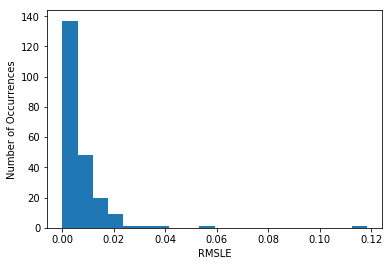

/Users/yangweineo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yangweineo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,col,correlation
305,linear_reg_errors,1.000000
107,Condition2_PosN,0.732607
105,Condition2_Norm,-0.588595
98,Condition1_PosN,0.525608
103,Condition2_Artery,0.310269
300,SaleCondition_Normal,-0.296982
133,OverallQual_10,0.285615
296,SaleCondition_Abnorml,0.282271
283,GarageCond_TA,-0.243149
278,GarageQual_TA,-0.239811


In [47]:
lr = lrdf.iloc[0]['Model']

def create_error_correlation_table(model,
                                   outcome_var,
                                   feature_set,
                                   dev_df):
    
    '''
    finds correlation between absolute value of error
    and each feature
    '''
    
    dev_preds = model.predict(dev_df[feature_set])
    dev_df = dev_df.reset_index()
    
    rmsles = []
    for i in range(len(dev_preds)):
        rmsles.append(sf.rmsle([dev_df[outcome_var][i]], [dev_preds[i]]))
        
    plt.clf()
    plt.hist(rmsles, bins=20)
    plt.xlabel("RMSLE")
    plt.ylabel("Number of Occurrences")
    plt.show()
    
    dev_df['linear_reg_errors'] = rmsles
    
    cols = []
    corrs = []
    for col in dev_df.columns:
        try:
            cor = np.corrcoef(abs(dev_df['linear_reg_errors']), dev_df[col])[0,1]
            cols.append(col)
            corrs.append(cor)
        except:
            pass
    
    corrs_df = pd.DataFrame(data={'col': cols, 'correlation': corrs})
    corrs_df = corrs_df.dropna(subset=['correlation'])
    return corrs_df
    
corrs_df = create_error_correlation_table(lr, 'LogSalePrice', feature_sets[-1], dev_df)
corrs_df.reindex(corrs_df.correlation.abs().sort_values(ascending=False).index)

### Deeper Dive into modeling

We intend to use this section to dive deeper into model interpretability, any insights we gained, and to talk through what types of models would be best for different use cases. 